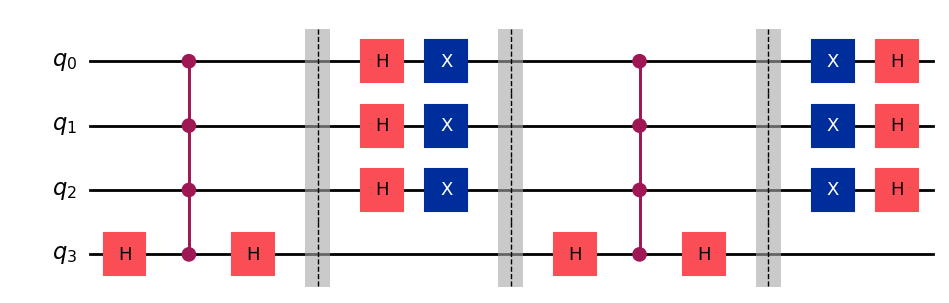

In [343]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.circuit.library import MCMT, ZGate
from qiskit.primitives import StatevectorSampler 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_distribution, plot_histogram
import math
import numpy
from mitiq import zne
from mitiq.interface.mitiq_qiskit.qiskit_utils import initialized_depolarizing_noise
import mthree
import matplotlib.pyplot as plt
from qiskit_ibm_runtime.fake_provider import FakePoughkeepsieV2
from qiskit_ibm_runtime import SamplerV2 as Sampler

noise_model = initialized_depolarizing_noise(noise_level=0.5)
optimal_num_iterations = math.floor (
    (math.pi/4)*(math.sqrt(16))
)
grover_circuit = QuantumCircuit(4)
indices = [ind for ind in range(3)]
grover_circuit.h(3)
grover_circuit.compose(MCMT(ZGate(), 3, 1), inplace=True)
grover_circuit.h(3)
grover_circuit.barrier()
for item in indices:
    grover_circuit.h(item)
for item in indices:
    grover_circuit.x(item)
grover_circuit.barrier()
grover_circuit.h(3)
grover_circuit.compose(MCMT(ZGate(), 3, 1), inplace=True)
grover_circuit.h(3)
grover_circuit.barrier()
for item in indices:
    grover_circuit.x(item)
for item in indices:
    grover_circuit.h(item)
grover_circuit.draw(output="mpl", style="iqp")




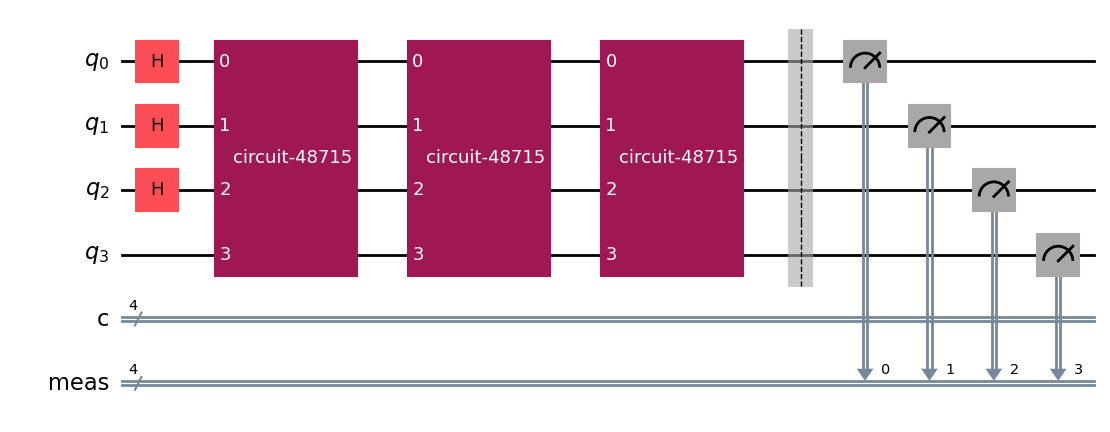

In [344]:
qc = QuantumCircuit(4,4)
for item in indices:
    qc.h(item)
qc.compose(grover_circuit.power(optimal_num_iterations), inplace=True)
qc.measure_all()
qc.draw(output="mpl", style="iqp")


In [345]:
backend = AerSimulator(noise_model=noise_model) 
real_backend = FakePoughkeepsieV2()
sampler = Sampler(mode=real_backend)


qc_decomposed = qc.decompose(reps=3)
qc_decomposed2 = qc_decomposed.decompose()




pm = generate_preset_pass_manager(backend=real_backend, optimization_level=1)
isa_qc = pm.run(qc)

real_backend.basis_gates()




AttributeError: 'FakePoughkeepsieV2' object has no attribute 'basis_gates'

In [ ]:
shots=8192
def ibmq_executor(circuit: QuantumCircuit, shots: int=8192) -> float:
    exec_circuit = transpile(
        circuit,
        backend=backend,
        basis_gates = noise_model.basis_gates,
        optimization_level=0, # Important to preserve folded gates.
    )
    job = backend.run(circuit, shots = 8192)
    counts = job.result().get_counts()
    expectation_value = counts.get("1111") / shots
    return expectation_value
unmitigated = ibmq_executor(qc)
mitigated = zne.execute_with_zne(qc, ibmq_executor)
print(f"Unmitigated result {unmitigated:.3f}")
print(f"Mitigated result {mitigated:.3f}")

AerError: 'unknown instruction: circuit-48485'

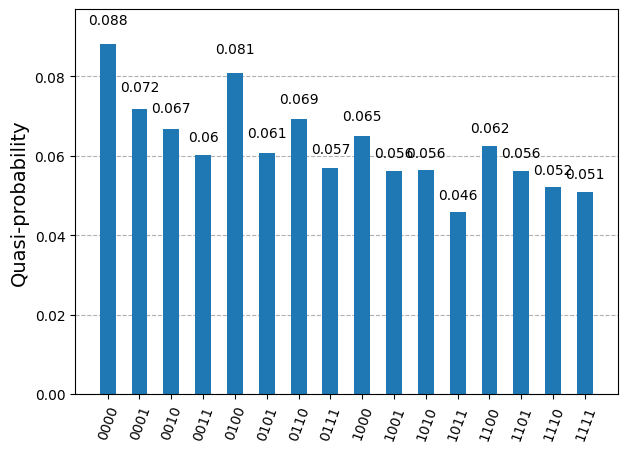

In [ ]:

mappings = mthree.utils.final_measurement_mapping(transpiled_qc)
dist = result[0].data.meas.get_counts()
plot_distribution(dist)


In [ ]:
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = 32
sampler.options.twirling.shots_per_randomization = 100
result_mitigated = sampler.run([transpiled_qc], shots=10000).result()
dist_mitigated = result_mitigated[0].data.meas.get_counts()
mit = mthree.M3Mitigation(real_backend)
mit.cals_from_system(mappings)
quasis = mit.apply_correction(dist_mitigated, mappings)


c:\anaconda3\envs\pioneer\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:337: UserWarning: Options {'twirling': {'enable_gates': True, 'num_randomizations': 32, 'shots_per_randomization': 100}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


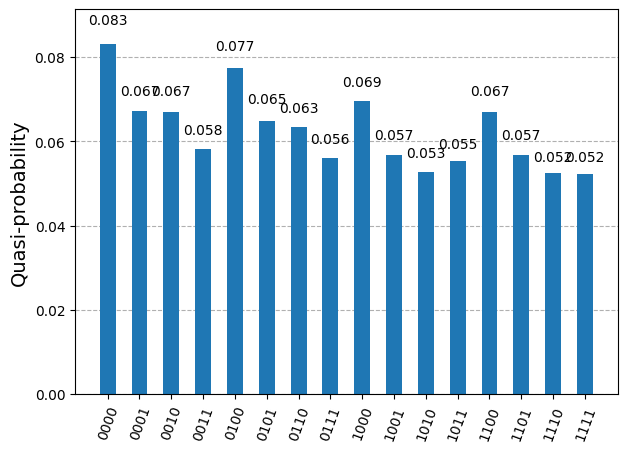

In [ ]:
plot_distribution(quasis)